# 16. 6th Attempt: Catch Up Faster

## 기보 읽어보기

오목을 학습시키는 것은, 돌을 아무 곳이나 마구잡이로 두는 친구에게
돌을 일렬로 놓으면 이긴다는 것을 가르치고,
상대도 같은 목표를 가지고 있으니 그걸 생각하라고 가르치는 것과 같습니다.
다만, 컴퓨터한테는 이런 말을 해주지도 못하고 알아듣지도 못해서
문제입니다만.

그래서 강화학습을 하면 직접 아무 곳이나 돌을 두다가 둘 중 누군가
이겼다고 하면 '저렇게 둬야 되는구나'라고 배우도록 합니다.
그런데 처음에 돌을 마구잡이로 던지는 사람이 있으면 흔히 오목을 둘 줄
아는 사람은 그냥 구석에 일렬로 돌을 나열하고 게임을 끝내버리면 됩니다.
그러면 이것을 보고 '저렇게 나열해야 이기구나'라는 것을 깨닫기야
하겠지만, 이걸 굳이 직접 하면서 배울 필요는 없습니다.

그래서 여기서는 본격적인 학습에 들어가기 전에
몇몇 유형의 기보를 주고 학습하는 식으로 일종의 initialization을 한 뒤
학습속도에 개선이 있는지 확인해봅니다.

개선의 기준은 이전 실험과 비교를 하며,
이전 실험에서는 약 1시간 동안 15000게임을 진행하였고,
(Google Colab기준 1000 게임당 4분)
학습 시작 후 16분이 지난 4000게임 쯤에서 mixed와의 승률 0%를 돌파,
32분이 지난 8000게임 쯤부터 `pt`와의 승률이 50%를 바라보기
시작했습니다.

### Environment

In [2]:
!rm -rf *
!git clone https://github.com/lumiknit/mock5.py
!mv mock5.py/mock5 .
!mv mock5.py/gen2_record/gen.cpp .
!mv mock5.py/gen2_record/read_record.py .
!g++ -O2 -fopenmp -o gen gen.cpp

Cloning into 'mock5.py'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 152 (delta 74), reused 121 (delta 47), pack-reused 0
Receiving objects: 100% (152/152), 40.10 KiB | 10.03 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [22]:
from mock5 import Mock5
from mock5.analysis import Analysis as M5Analysis
import mock5.agent_random as m5rand
import mock5.agent_analysis_based as m5aa
import mock5.agent_ad as m5ad
import mock5.agent_pt as m5pt
import mock5.agent_df as m5df

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import os
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: {}".format(device))

Device: cuda


### Board Size

In [4]:
# Board Size
W = 15
H = W

### Agent & Policy Transformer

In [5]:
def fn_name(fn):
  if hasattr(fn, 'name'): return fn.name
  else: return repr(fn)
  
def agent(pi, epsilon=0):
  # pi must return array of non-negative values
  def c(game):
    w, h = game.width, game.height
    m, p = np.ones(h * w), np.array(pi(game))
    for i in range(h * w):
      if game.board[i] != 0: m[i], p[i] = 0, 0
    s = p.sum()
    if np.random.uniform() < epsilon or s == 0:
      s = m.sum()
      if s == 0: return None, None # Cannot do anything
      else: idx = np.random.choice(h * w, p=(m / s))
    else: idx = np.random.choice(h * w, p=(p / s))
    return idx // w, idx % w
  c.name = 'stochastic({})'.format(fn_name(pi))
  return c

In [6]:
def softmax(arr, tau=1.0):
  arr = np.array(arr, dtype=np.float64)
  arr /= tau
  m = max(arr)
  z = np.exp(arr - m)
  return z / z.sum()

def pt_softmax(policy, tau=1.0):
  def p(game):
    p = policy(game)
    return softmax(p, tau=tau)
  p.name = 'pt_softmax({},tau={})'.format(fn_name(policy), tau)
  return p

def pt_norm(policy):
  def p(game):
    p = policy(game)
    return p / p.max()
  p.name = 'pt_norm({})'.format(fn_name(policy))
  return p

def policy_uniform(game):
  return np.ones(game.height * game.width)
policy_uniform.name = 'uniform'

In [7]:
def test_agents(num_game, agent1, agent2):
  w1, w2 = 0, 0
  c1, c2 = 0, 0
  for i in range(num_game):
    g = Mock5(H, W)
    result = g.play(agent1, agent2,
                    print_intermediate_state=False, print_messages=False)
    if result == 1:
      w1 += 1
      c1 += len(g.history)
    elif result == 2:
      w2 += 1
      c2 += len(g.history)
  print("-- Test Result --")
  print("* Agent1 = {} \n* Agent2 = {}".format(
      fn_name(agent1), fn_name(agent2)))
  print("Total : {:5d}".format(num_game))
  print("A1 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w1, w1 / num_game, c1 / max(1, w1)))
  print("A2 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w2, w2 / num_game, c2 / max(1, w2)))

In [8]:
def agent_mixed(game):
  a = np.random.uniform()
  if a < 0.4: return m5aa.agent(game)
  elif a < 0.8: return m5ad.agent(game)
  elif a < 0.9: return m5pt.agent(game)
  else: return m5df.agent(game)
agent_mixed.name = 'agent-mixed-analysis-based'

### Neural Network

In [9]:
class Flatten(nn.Module):
  def forward(self, x):
    if len(x.shape) == 3: return x.view(-1)
    else: return x.flatten(1, -1)

class FixedTempSoftmax(nn.Module):
  def __init__(self, dim, tau):
    super(FixedTempSoftmax, self).__init__()
    self.dim = dim
    self.tau = np.exp(tau)
  def forward(self, x):
    return nn.functional.softmax(x / self.tau, self.dim)

class TempSoftmax(nn.Module):
  def __init__(self, dim, tau=0):
    super(TempSoftmax, self).__init__()
    self.dim = dim
    self.tau = nn.Parameter(torch.tensor([tau], dtype=torch.float))
  def forward(self, x):
    return nn.functional.softmax(x / torch.exp(self.tau), self.dim)

In [10]:
## nn
def new_nn():
  net = nn.Sequential(
      # Conv01
      nn.Conv2d(3, 128, 3, padding='same'),
      nn.GELU(),
      # Conv02
      nn.Conv2d(128, 64, 3, padding='same'),
      nn.GELU(),
      # Conv03
      nn.Conv2d(64, 32, 3, padding='same'),
      nn.GELU(),
      # Conv04
      nn.Conv2d(32, 32, 3, padding='same'),
      nn.GELU(),
      # Conv05
      nn.Conv2d(32, 32, 3, padding='same'),
      nn.GELU(),
      # Conv06
      nn.Conv2d(32, 32, 3, padding='same'),
      nn.GELU(),
      # Conv07
      nn.Conv2d(32, 1, 5, padding='same'),
      nn.GELU(),
      # Flatten
      Flatten(),
      # Softmax
      FixedTempSoftmax(tau=0, dim=-1)
  ).to(device)
  return net

def init_nn():
  global policy, policy_backs
  policy = new_nn()
  policy_backs = []
  save_policy()

def save_policy():
  global policy_backs
  n = new_nn()
  n.load_state_dict(policy.state_dict())
  policy_backs = (policy_backs + [n])[-10: ]

In [11]:
def policy_model(net):
  def c(game):
    X = game.tensor(dtype=torch.float).unsqueeze(dim=0).to(device)
    with torch.no_grad():
      p = net(X)
    arr = p.squeeze().to('cpu').numpy()
    return arr
  c.name = 'model({:x})'.format(id(net))
  return c

In [12]:
def loss_fn(policy, v):
  return - (v * torch.log(1e-8 + policy)).mean()

In [13]:
class Stat:
  def __init__(self, n=0, w=0, l=0, d=0): self.n, self.w, self.l, self.d = n, w, l, d
  def dup(self):
    return Stat(self.n, self.w, self.l, self.d)
  def __sub__(self, other):
    return Stat(self.n - other.n, self.w - other.w, self.l - other.l, self.d - other.d)
  def win(self):
    self.n += 1
    self.w += 1
  def lose(self):
    self.n += 1
    self.l += 1
  def draw(self):
    self.n += 1
    self.d += 1
  def update_by_result(self, result):
    self.n += 1
    if result == 1: self.w += 1
    elif result > 1: self.l += 1
    else: self.d += 1
  def win_rate(self):
    if self.n >= 1: return (self.w + 0.5 * self.d) / self.n
    else: return np.nan

여기서부터는 data를 실제 플레이로 만들 수도 있고
임의로 가져올 수 있으므로,
agent 등을 대신하여 data loader 등을 받습니다.

직접 게임을 진행한 경우에는 이긴 사람의 기보만을
'좋은 수'라고 판단하고 reward를 주지만,
알고리즘으로 생성된 기보의 경우에는
양측이 모두 최선의 수를 두었다고 판단하고
모두 positive reward를 주도록 합니다.
(즉, 좋은 수 나쁜 수를 떠나서 일단은 이런 느낌으로
돌을 둬야하는구나를 학습시킵니다.)

In [14]:
def append_game_replay(Xs, As, Vs, gamma, game, result, winner_only=True):
  reward = 1 if result != 0 else 0.3
  # Append to Batch
  for f in range(2):
    for r in range(4):
      g = game.replay(angle=r, flip=f)
      while len(g.history) > 0:
        a = g.history[-1]
        g.undo()
        if not winner_only or g.player == 3 - game.player:
          Xs.append(g.tensor())
          As.append(a)
          Vs.append(reward)
        reward *= gamma

In [15]:
import os
from read_record import file_to_int_pair_iter

def gen_episode_by_generator(num_game, rnd):
  def generator(Xs, As, Vs, gamma, stat):
    filename = "temp.data"
    os.system("./gen {} {} {} {} {}".format(filename, num_game, H, W, rnd))
    i_iter = file_to_int_pair_iter(filename)
    left = 0
    game, result = None, None
    for i0, i1 in i_iter:
      if left <= 0:
        game = Mock5(H, W)
        result, left = i0, i1
      else:
        left -= 1
        game.place_stone_at_index(i0)
      if left == 0:
        if result != game.check_win():
          raise ValueError
        append_game_replay(Xs, As, Vs, gamma, game, result, winner_only=False)
    return num_game
  return generator

In [16]:
def gen_episode_by_play(
    agent1,
    agent2
):
  def generator(Xs, As, Vs, gamma, stat):
    # Run Game
    game = Mock5(H, W)
    result = game.play(agent1, agent2,
      print_intermediate_state=False, print_messages=False)
    # Make reward
    stat.update_by_result(result)
    append_game_replay(Xs, As, Vs, gamma, game, result)
    return 1
  return generator

In [17]:
# REINFORCE
def learn(
    opt,
    n_episode,
    gen_episode, #: take (Xs, As, Vs, gamma, stat)
    n_epoch,
    gamma,
    batch_size,
    interval_stat
):
  stat = Stat()
  last_stat = stat.dup()
  last_stat_epi = 0
  loss_inc = 0
  Xs, As, Vs = [], [], []
  epi = 0
  while epi < n_episode:
    # Generate episode
    inc_epi = gen_episode(Xs, As, Vs, gamma, stat)
    if type(inc_epi) is int: epi += inc_epi
    # If batch is full enough, perform gradient ascent
    if len(Xs) >= batch_size:
      # Tensor-fy
      X = torch.stack(Xs)
      X += (torch.rand(X.shape) - 0.5) * 0.01
      X = X.to(device)
      A = torch.tensor(As).unsqueeze(dim=1).to(device)
      V = torch.tensor(Vs, dtype=torch.float).to(device)
      Xs, As, Vs = [], [], []
      # Learn
      loss_list = []
      for e in range(n_epoch):
        opt.zero_grad()
        pi_s = policy(X)
        pi_sa = pi_s.gather(1, A).squeeze(dim=1)
        loss = loss_fn(pi_sa, V)
        loss.backward()
        opt.step()
        loss_list.append(loss.mean().item())
      loss_inc += loss_list[0] - loss_list[-1]
      # Print status and evaluate
      if epi - last_stat_epi >= interval_stat:
        save_policy()
        print("----------")
        print("Ep #{:<6d} Loss Change Accum {:13.10f}".format(
          epi, loss_inc))
        print("  Win Rate {:8.4f}% ({}w + {}d + {}l = {})".format(
            100 * stat.win_rate(), stat.w, stat.d, stat.l, stat.n))
        dstat = stat - last_stat
        print("   WR Diff {:8.4f}% ({}w + {}d + {}l = {})".format(
            100 * dstat.win_rate(), dstat.w, dstat.d, dstat.l, dstat.n))
        test_a = agent(policy_model(policy))
        #test_agents(10, test_a, m5rand.agent)
        test_agents(10, test_a, m5pt.agent)
        last_stat, last_stat_epi = stat.dup(), epi
        loss_inc = 0

### Learning

이전에 약 1시간 동안 15000개의 게임으로 배운 것과 동일하지만,
처음 1500개의 게임은 직접 플레이 하지 않고
알고리즘으로 생성된 기보를 읽는 식으로 진행합니다.

In [30]:
def run():
  init_nn()

  timer = time.process_time()

  opt = optim.Adam(policy.parameters(),
                  lr=2e-3,
                  weight_decay=1e-5)
  
  learn(
      opt = opt,
      n_episode = 1500,
      gen_episode = gen_episode_by_generator(1, np.random.uniform() * 0.04),
      n_epoch = 2,
      gamma = 0.995,
      batch_size = 1,
      interval_stat = 200)
  
  print("\n#-- Pre Train : {:.4f} sec elapsed\n".format(time.process_time() - timer))
  timer = time.process_time()
  
  #opt = optim.Adam(policy.parameters(),
  #                lr=5e-4,
  #                weight_decay=1e-8)
  opt = optim.SGD(policy.parameters(),
                  lr=1e-2,
                  momentum=0.8,
                  weight_decay=1e-6)

  agent1 = agent(policy_model(policy))
  agent2 = agent_mixed
  learn(
      opt = opt,
      n_episode = 13500,
      gen_episode = gen_episode_by_play(agent1, agent2),
      n_epoch = 2,
      gamma = 0.995,
      batch_size = 50,
      interval_stat = 500)
  
  print("\n#-- Main Train : {:.4f} sec elapsed\n".format(time.process_time() - timer))
  timer = time.process_time()

run()

----------
Ep #200    Loss Change Accum  9.9980560541
  Win Rate      nan% (0w + 0d + 0l = 0)
   WR Diff      nan% (0w + 0d + 0l = 0)
-- Test Result --
* Agent1 = stochastic(model(7fb8dd24cd50)) 
* Agent2 = agent-pt
Total :    10
A1 Win:     0 (0.000) (avg.mov    0.0)
A2 Win:    10 (1.000) (avg.mov   13.8)
----------
Ep #400    Loss Change Accum 21.8656019866
  Win Rate      nan% (0w + 0d + 0l = 0)
   WR Diff      nan% (0w + 0d + 0l = 0)
-- Test Result --
* Agent1 = stochastic(model(7fb8dd24cd50)) 
* Agent2 = agent-pt
Total :    10
A1 Win:     0 (0.000) (avg.mov    0.0)
A2 Win:    10 (1.000) (avg.mov   14.6)
----------
Ep #600    Loss Change Accum 18.6820520610
  Win Rate      nan% (0w + 0d + 0l = 0)
   WR Diff      nan% (0w + 0d + 0l = 0)
-- Test Result --
* Agent1 = stochastic(model(7fb8dd24cd50)) 
* Agent2 = agent-pt
Total :    10
A1 Win:     0 (0.000) (avg.mov    0.0)
A2 Win:    10 (1.000) (avg.mov   18.6)
----------
Ep #800    Loss Change Accum 21.7962926179
  Win Rate      nan% (

## Evaluation


챕터 15의 학습 경과와 비교하였을 때,
`mixed`와의
windowed win rate는 다음과 같습니다.

| #Ep | W/O pretrain | W/ pretrain |
|----:|-------------:|------------:|
|  500| 0.00%| -|
| 1000| 0.00%| -|
| 1500| 0.00%| -|
| 2000| 0.00%| 0.80%|
| 2500| 0.00%| 3.00%|
| 3000| 0.00%| 3.20%|
| 3500| 0.00%| 5.00%|
| 4000| 0.20%| 4.60%|
| 4500| 0.20%| 5.00%|
| 5000| 0.00%| 9.60%|
| 5500| 0.20%| 7.60%|
| 6000| 0.80%| 10.20%|
| 6500| 1.19%| 8.40%|
| 7000| 3.20%| 12.20%|
| 7500| 3.20%| 11.60%|
| 8000| 5.17%| 9.60%|
| 8500| 6.39%| 11.80%|
| 9000| 5.60%| 9.80%|
| 9500| 9.16%| 15.17%|
|10000| 8.38%| 16.80%|
|10500| 11.78%| 12.60%|
|11000| 12.38%| 12.40%|
|11500| 13.55%| 12.80%|
|12000| 11.60%| 14.00%|
|12500| 15.34%| 11.60%|
|13000| 13.60%| 16.00%|
|13500| 17.56%| 17.00%|
|14000| 15.20%| 18.00%|
|14500| 19.40%| 19.00%|

기보학습 없이 강화학습을 시작한 경우에는
약 4000번의 게임을 진행하고 나서야 처음으로
승리하는 경우가 몇번 나타나지만,
기보를 일부 넣어준 경우에는
강화학습을 시작하고 나서부터 일부 이기는 경우가 있음을
확인할 수 있습니다.

또한 승률 10% 정도에 도달하는 시간도 기보를 미리
넣은 경우에 2배가량 빠른 것을 확인할 수 있습니다.

다만, 약 10000번의 게임을 넘어간 뒤부터는
두 방식이 그리 큰 차이를 보이지 않는 것을
확인할 수 있으며, 계속 선형적으로 승률이 증가하지 않고
15% 선에서부터 정체가 생김을 확인할 수 있습니다.


학습 시간은 처음에 기보를 생성해서 입력하는 과정은
$111.3 \text{ sec} / 1500 \text{ games}
\simeq 0.074 \text{ sec/games}$ 정도의 시간이 걸리며,
이후에는
$3338.1 \text{ sec} / 1500 \text{ games}
\simeq 0.247 \text{ sec/games}$ 정도의 시간이
걸립니다.
즉, 직접 게임을 하는 것보다 기보를 넣는 편이 기보 하나당
처리하는 시간이 1/3정도로 훨씬 짧음을 확인할 수 있습니다.

In [31]:
a = [m5aa, m5ad, m5pt, m5df]
for i in range(len(a)):
    test_agents(40, agent(policy_model(policy)), a[i].agent)

-- Test Result --
* Agent1 = stochastic(model(7fb8dd24cd50)) 
* Agent2 = agent-analysis-based
Total :    40
A1 Win:     2 (0.050) (avg.mov   27.0)
A2 Win:    38 (0.950) (avg.mov   43.0)
-- Test Result --
* Agent1 = stochastic(model(7fb8dd24cd50)) 
* Agent2 = agent-analysis-defensive
Total :    40
A1 Win:     7 (0.175) (avg.mov   34.7)
A2 Win:    33 (0.825) (avg.mov   37.1)
-- Test Result --
* Agent1 = stochastic(model(7fb8dd24cd50)) 
* Agent2 = agent-pt
Total :    40
A1 Win:    17 (0.425) (avg.mov   30.5)
A2 Win:    23 (0.575) (avg.mov   36.5)
-- Test Result --
* Agent1 = stochastic(model(7fb8dd24cd50)) 
* Agent2 = agent-df
Total :    40
A1 Win:    12 (0.300) (avg.mov   44.8)
A2 Win:    28 (0.700) (avg.mov   55.5)


 [ Turn  39 ; 2P's turn (tone = X) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E
--+------------------------------
0 | . . . . . . . . . . . . . . .
1 | . . . . . . . . . . . . . . .
2 | . . . . . . . . . . . . . . .
3 | . . . . . . . X . . . X . . .
4 | . . . . X . . . . O X O X X .
5 | . . . . . . . . . O X O O . .
6 | . . . . . . O X X X O O . . .
7 | . . . . . . . O X O O O X . .
8 | . . . . . . X O O O X O X . .
9 | . . . . . . O X X X O . . . .
A | . . . . . X . . O . . . . . .
B | . . . . . . . O . . . . . . .
C | . . . . . . . . . . . . . . .
D | . . . . . . . . . . . . . . .
E | . . . . . . . . . . . . . . .
1p (stochastic(model(7fb8dd24cd50))) win!


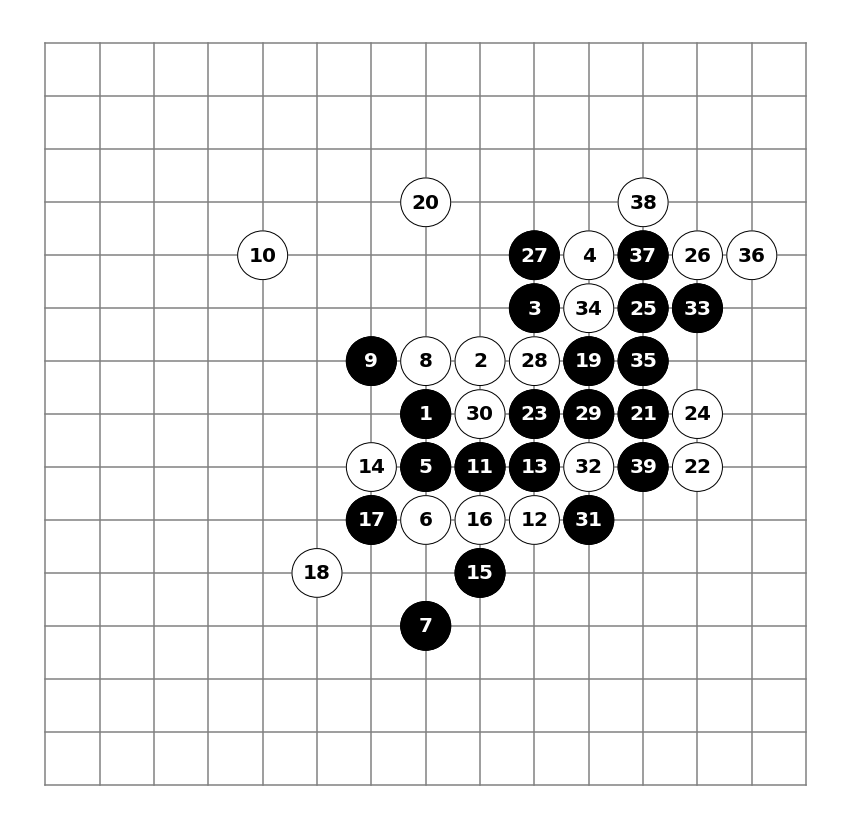

In [35]:
m = Mock5(H, W)
m.play(agent(policy_model(policy)), m5df.agent,
  print_intermediate_state=False)
m.plot()
plt.show()
plt.close()

In [36]:
test_agents(100, agent(policy_model(policy)), m5df.agent)

-- Test Result --
* Agent1 = stochastic(model(7fb8dd24cd50)) 
* Agent2 = agent-df
Total :   100
A1 Win:    40 (0.400) (avg.mov   31.6)
A2 Win:    60 (0.600) (avg.mov   64.2)


그 외의 agent와 대결해봤을 때,
이전과 마찬가지로 `aa`, `ad`에는 한참 못 미치지만,
`pt`, `df`와는 어느 정도 대등하게 게임하는 것을
확인할 수 있고, 이는 이전 챕터에서 15000게임을 학습했을
때와 유사한 결과입니다.

## 고찰

- Batch size는 학습에 크게 영향을 미치는
hyperparameter로, 크게 잡으면 조금 느릴 수는 있어도
안정적인 방향으로 수렴해가며, 반대로 batch size가 작아지게
되면 parameter의 변화는 커지지만 방향이 튀는 경우가 많이
생기게 됩니다.
위에서는 많은 기보를 짧은 시간에 뽑아내는 것이 가능하다보니
일부러 batch size를 크게 주고 학습이 어떻게 되나
확인을 해보기도 했는데, 오히려 아무것도 학습되지 않는
상황이 생겼던 것 같습니다.
다른 강화학습의 경우는 몰라도, 오목처럼 state와 action이
많은 경우에는 안정적으로 수렴시키기보다는
나름 괜찮은 방향으로 빠르게 흔들어서 local optimum들을
빠르게 빠져나오는 편이 더 나은 것 같습니다.
- 이번에 학습 속도가 조금 빨라졌다 싶었는데도 승률 20%에서
머무는 것을 보면 neural network의 complexity가
부족하지 않았나 싶습니다.
- 학습 과정에서 승률 변화를 보면 일정한 경향은 별로 없고
왔다갔다 하는 것을 볼 수 있습니다.
이렇게 되는 가장 큰 이유는 학습 과정이 가장 최근에 둔
게임에서 좋다고 판단한 수만 강화하는 식으로 진행되어서
그러지 않은가 싶습니다.
결국에는 이 방법 외에는 global optimum에 가까워질
방법이 없기에 이 방식은 유지하겠지만,
replay memory를 도입하든지 해서 과거의 기보를
다시 끄집어내서 학습하는 것이 필요할지도 모르겠습니다.